In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pprint

import flax.linen as nn
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import (
    Predictive,
    SVI,
    TraceMeanField_ELBO,
    autoguide,
    init_to_feasible,
)
from numpyro.util import format_shapes
from numpyro.contrib.module import random_flax_module, flax_module
import optax

### Helper functions

In [2]:
def generate_data():
    # Parameters
    a = 0.3
    b = 2.5
    s = 0.25

    # True function
    def y_true(x):
        return a + jnp.sin(x * 2 * jnp.pi / b)

    # Noisy function
    def y_noise(x, key):
        return y_true(x) + s * jax.random.normal(key, x.shape)

    return y_true, y_noise

### Visualize the toy dataset

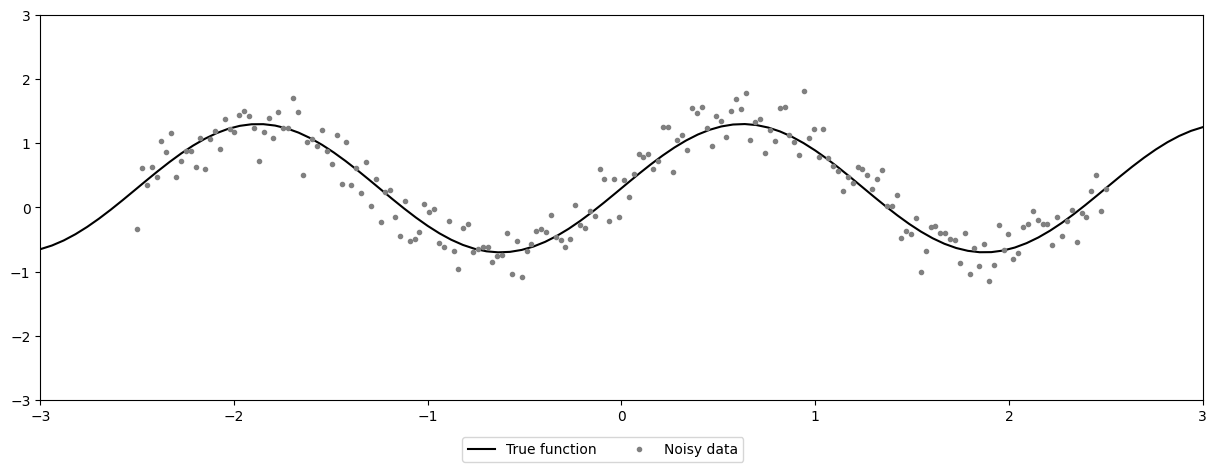

In [11]:
x_train = jnp.linspace(-2.5, 2.5, 200)
x_test = jnp.linspace(-3.0, 3.0, 100)
true_fn, noise_fn = generate_data()
y_test = true_fn(x_test)
y_train = noise_fn(x_train, jax.random.key(0))


fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(x_test, y_test, label="True function", color="black")
ax.plot(x_train, y_train, ".", color="gray", label="Noisy data")
ax.set_ylim(-3.0, 3.0)
ax.set_xlim(-3.0, 3.0)
fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=4,
)

## The probabilistic programming in a nutshell

Table of contents:
- The Bayesian inference
- 

Terms:
- `model`: a probabilistic model, the process that generates the data.
- `guide`: a variational distribution, the approximation of the posterior distribution.
- **marginal distribution**: Typically, this is sum or integral of some variables in a joint distribution to get the distribution of the remaining variables. Imagine, you have 3 coins with difference biases in the box. The marginal distribution is the probability distribution of the flip result regardless of which coin you randomly pick.

References:
- [Pyro's introduction](https://pyro.ai/examples/intro_long.html)
   > Great for beginners about probabilistic programming terminology and concepts.

In [5]:
def safe_shape(a):
    try:
        return a.shape
    except AttributeError:
        return type(a)


def report_shape(a):
    return jax.tree.map(safe_shape, a)


# Simple flax MLP model
class MLP(nn.Module):
    layers: list[int]

    @nn.compact
    def __call__(self, x):
        for hidden in self.layers:
            x = nn.Dense(hidden)(x)
            x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x


def make_bmlp_model(layer_size: list[int] = [5], direct_model: bool = False):
    def probabilistic_model(x: jnp.ndarray, y: jnp.ndarray | None = None):
        """This model place the param within the probabilistic model itself.
           The resulting model is not BNN, but a deterministic model with uncertainty from sigma.

        Args:
            x (jnp.ndarray): point the model is evaluated at
            y (jnp.ndarray | None, optional): The function evaluated at x. Defaults to None.

        Returns:
            _type_: The evaluated at x
        """

        # Expect x to be shape of (...batch_dims, 1)
        mlp = flax_module(
            "MLP",
            MLP(layer_size),
            input_shape=x.shape,
        )

        # Output shape is (..., 1)
        mu = mlp(x)
        # So we squeeze the last dimension
        mu = jnp.squeeze(mu, axis=-1)

        sigma = numpyro.sample("MLP/sigma", dist.LogNormal(0, 1))

        return numpyro.sample("MLP/y", dist.Normal(mu, sigma), obs=y)  # type: ignore

    def probabilistic_model_v2(x: jnp.ndarray, y: jnp.ndarray | None = None):
        """This model place the param to guide, the parameters are sample from the guide.
           Thus the resulting model is a BNN.

        Args:
            x (jnp.ndarray):
            y (jnp.ndarray | None, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """

        # Expect x to be shape of (...batch_dims, 1)
        mlp = random_flax_module(
            "MLP",
            MLP(layer_size),
            prior=dist.Normal(0.0, 1.0),
            input_shape=x.shape,
        )

        # Output shape is (..., 1)
        mu = mlp(x)
        # So we squeeze the last dimension
        mu = jnp.squeeze(mu, axis=-1)

        sigma = numpyro.sample("MLP/sigma", dist.LogNormal(0, 1))

        return numpyro.sample("MLP/y", dist.Normal(mu, sigma), obs=y)  # type: ignore

    return probabilistic_model_v2 if not direct_model else probabilistic_model


def get_default_optimizer(n_iterations):
    return optax.adamw(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=1e-6,
            peak_value=1e-2,
            warmup_steps=int(0.1 * n_iterations),
            decay_steps=n_iterations,
            end_value=1e-6,
        )
    )

### `model` and `guide` Engineering
At first, the boundary between `model` and `guide` might not so clear. But, the `model` is the process that generates the data, and the `guide` is the approximation of the posterior distribution. The `model` is the generative process, and the `guide` is the inference process.

In [6]:
# To inspect the probabilistic model, this is the way to do it.
model = make_bmlp_model(direct_model=True)
model_trace = handlers.trace(handlers.seed(model, jax.random.key(0))).get_trace(
    x_train.reshape(-1, 1)
)
print(format_shapes(model_trace, title="Model shapes"))
guide = autoguide.AutoNormal(model)
guide_trace = handlers.trace(handlers.seed(guide, jax.random.PRNGKey(0))).get_trace(
    x_train.reshape(-1, 1)
)
print("")
print(format_shapes(guide_trace, title="Guide shapes"))

# If we use this model to do inference with SVI, this is how to check the parameter being inferred.
# Beware, that the type of instace of optimizer passed to SVI is very important.
# As the code to do further inspection will not be the same.
# E.g. passing `optax` without `numpyro.optim.optax_to_numpyro` will resulting in different behavior.
svi = SVI(
    model=model,
    guide=guide,
    optim=numpyro.optim.optax_to_numpyro(get_default_optimizer(1000)),
    loss=TraceMeanField_ELBO(),
)

svi_state = svi.init(jax.random.PRNGKey(0), x_train.reshape(-1, 1))
print("\nInitial state")
pprint.pprint(report_shape(svi_state.optim_state[1][0]))

  Model shapes      
  Param Sites:      
    MLP$params      
 Sample Sites:      
MLP/sigma dist     |
         value     |
    MLP/y dist 100 |
         value 100 |

        Guide shapes        
        Param Sites:        
  MLP/sigma_auto_loc        
MLP/sigma_auto_scale        
      MLP/y_auto_loc     100
    MLP/y_auto_scale     100
       Sample Sites:        
      MLP/sigma dist       |
               value       |
          MLP/y dist 100   |
               value 100   |

Initial state
{'MLP$params': {'Dense_0': {'bias': (5,), 'kernel': (1, 5)},
                'Dense_1': {'bias': (1,), 'kernel': (5, 1)}},
 'MLP/sigma_auto_loc': (),
 'MLP/sigma_auto_scale': (),
 'MLP/y_auto_loc': (100,),
 'MLP/y_auto_scale': (100,)}


### Learning and Inference using non-BNN model

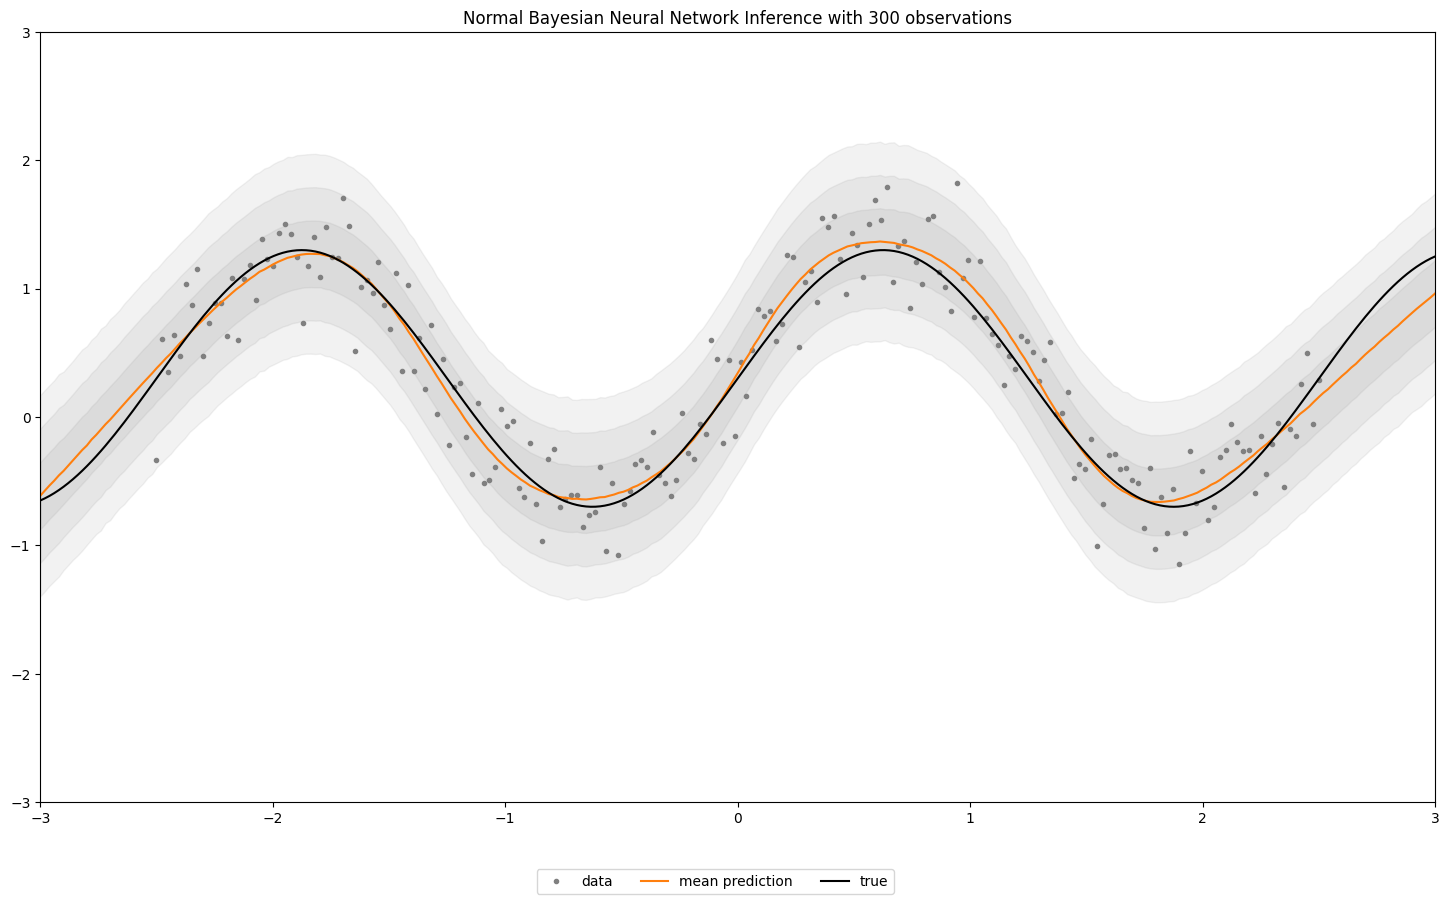

In [12]:
n_iterations = 10000
optimizer = get_default_optimizer(n_iterations=n_iterations)
key = jax.random.key(0)
key, subkey = jax.random.split(key)


model = make_bmlp_model(direct_model=True)
guide = autoguide.AutoNormal(model, init_loc_fn=init_to_feasible)

svi = SVI(
    model,
    guide,
    numpyro.optim.optax_to_numpyro(optimizer),
    TraceMeanField_ELBO(),
)

key, subkey = jax.random.split(key)

svi_result = svi.run(
    rng_key=subkey,
    num_steps=int(n_iterations * 1.2),
    x=x_train.reshape(-1, 1),
    y=y_train,
    progress_bar=False,
)

params, losses = svi_result.params, svi_result.losses
predictive = Predictive(model, guide=guide, params=params, num_samples=20_000)
key, subkey = jax.random.split(key)
x_test = jnp.linspace(-3.0, 3.0, num=300).reshape(-1, 1)

samples = predictive(
    subkey,
    x=x_test,
)

y_pred = samples["MLP/y"]
# plot the results
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x_train, y_train, ".", label="data", color="gray")
ax.plot(x_test, y_pred.mean(0), "-", label="mean prediction", color="C1")
# STD of the prediction
for std_factor in [1, 2, 3]:
    ax.fill_between(
        x_test.reshape(-1),
        y_pred.mean(0) - std_factor * y_pred.std(0),
        y_pred.mean(0) + std_factor * y_pred.std(0),
        alpha=0.10,
        color="gray",
    )

ax.plot(x_test, true_fn(x_test), label="true", color="black")
ax.set_title(
    f"Normal Bayesian Neural Network Inference with {x_test.shape[0]} observations"
)
ax.set_ylim(-3.0, 3.0)
ax.set_xlim(-3.0, 3.0)
fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=4,
)

### Using model with BNN

In [13]:
# Now let's do it again with BNN model
model = make_bmlp_model(direct_model=False)
model_trace = handlers.trace(handlers.seed(model, jax.random.key(0))).get_trace(
    x_train.reshape(-1, 1)
)
print(format_shapes(model_trace, title="Model shapes"))
guide = autoguide.AutoNormal(model)
guide_trace = handlers.trace(handlers.seed(guide, jax.random.PRNGKey(0))).get_trace(
    x_train.reshape(-1, 1)
)
print("")
print(format_shapes(guide_trace, title="Guide shapes"))

svi = SVI(
    model=model,
    guide=guide,
    optim=numpyro.optim.optax_to_numpyro(get_default_optimizer(1000)),
    loss=TraceMeanField_ELBO(),
)

svi_state = svi.init(jax.random.PRNGKey(0), x_train.reshape(-1, 1))
print("\nInitial state")
pprint.pprint(report_shape(svi_state.optim_state[1][0]))

           Model shapes          
           Param Sites:          
             MLP$params          
          Sample Sites:          
  MLP/Dense_0.bias dist     | 5  
                  value     | 5  
MLP/Dense_0.kernel dist     | 1 5
                  value     | 1 5
  MLP/Dense_1.bias dist     | 1  
                  value     | 1  
MLP/Dense_1.kernel dist     | 5 1
                  value     | 5 1
         MLP/sigma dist     |    
                  value     |    
             MLP/y dist 200 |    
                  value 200 |    

                 Guide shapes            
                 Param Sites:            
    MLP/Dense_0.bias_auto_loc       5    
  MLP/Dense_0.bias_auto_scale       5    
  MLP/Dense_0.kernel_auto_loc   1   5    
MLP/Dense_0.kernel_auto_scale   1   5    
    MLP/Dense_1.bias_auto_loc       1    
  MLP/Dense_1.bias_auto_scale       1    
  MLP/Dense_1.kernel_auto_loc   5   1    
MLP/Dense_1.kernel_auto_scale   5   1    
           MLP/sigma_auto_loc      

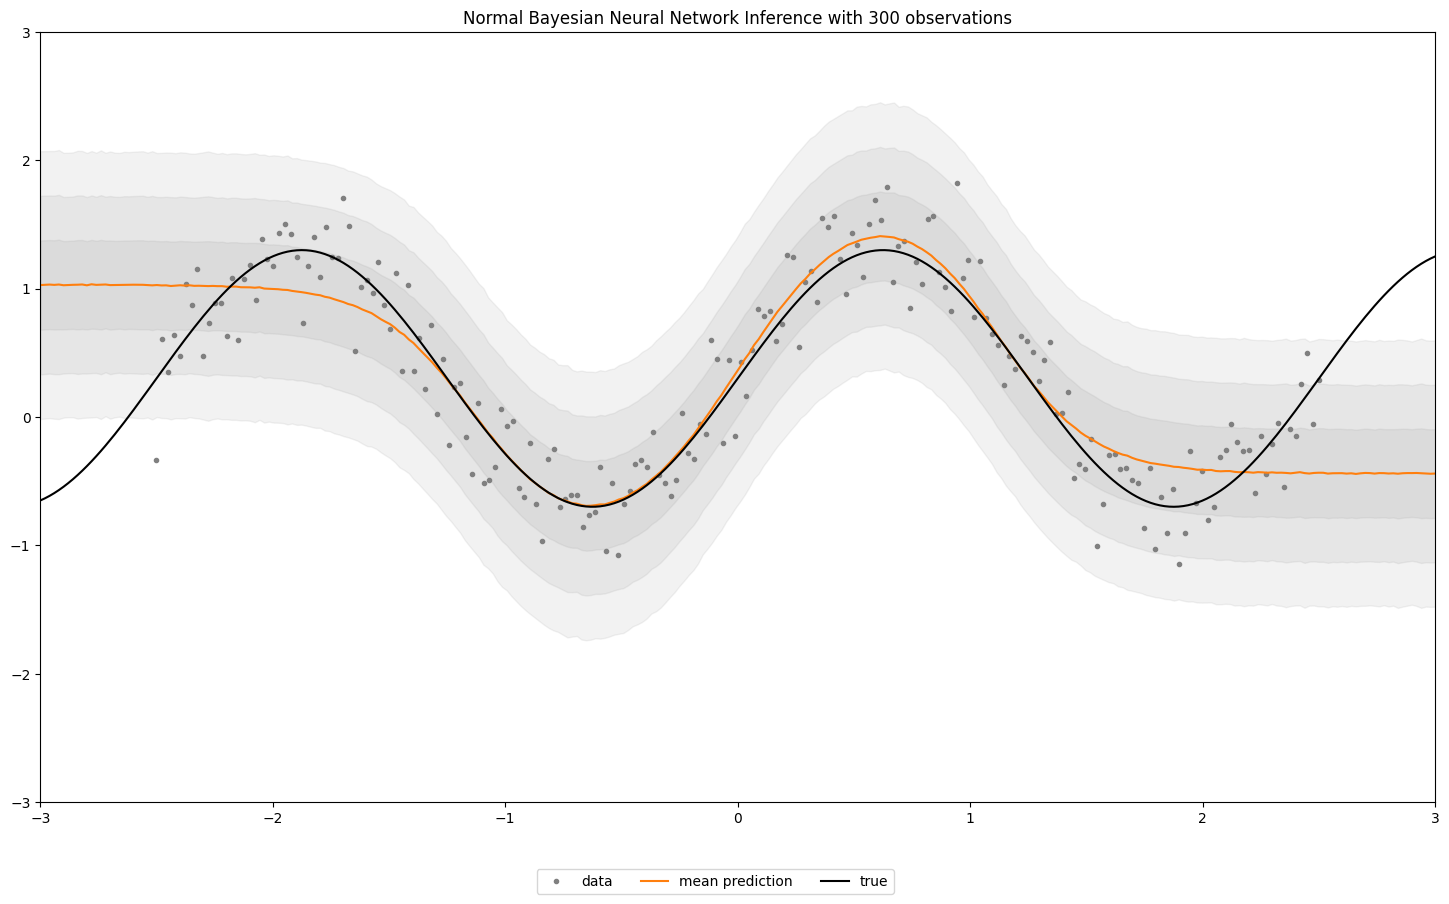

In [14]:
n_iterations = 10000
optimizer = get_default_optimizer(n_iterations=n_iterations)
key = jax.random.key(0)
key, subkey = jax.random.split(key)


model = make_bmlp_model(direct_model=False)
guide = autoguide.AutoNormal(model, init_loc_fn=init_to_feasible)

svi = SVI(
    model,
    guide,
    numpyro.optim.optax_to_numpyro(optimizer),
    TraceMeanField_ELBO(),
)

key, subkey = jax.random.split(key)

svi_result = svi.run(
    rng_key=subkey,
    num_steps=int(n_iterations * 1.2),
    x=x_train.reshape(-1, 1),
    y=y_train,
    progress_bar=False,
)

params, losses = svi_result.params, svi_result.losses
predictive = Predictive(model, guide=guide, params=params, num_samples=20_000)
key, subkey = jax.random.split(key)
x_test = jnp.linspace(-3.0, 3.0, num=300).reshape(-1, 1)

samples = predictive(
    subkey,
    x=x_test,
)

y_pred = samples["MLP/y"]
# plot the results
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x_train, y_train, ".", label="data", color="gray")
ax.plot(x_test, y_pred.mean(0), "-", label="mean prediction", color="C1")
# STD of the prediction
for std_factor in [1, 2, 3]:
    ax.fill_between(
        x_test.reshape(-1),
        y_pred.mean(0) - std_factor * y_pred.std(0),
        y_pred.mean(0) + std_factor * y_pred.std(0),
        alpha=0.10,
        color="gray",
    )

ax.plot(x_test, true_fn(x_test), label="true", color="black")
ax.set_title(
    f"Normal Bayesian Neural Network Inference with {x_test.shape[0]} observations"
)
ax.set_ylim(-3.0, 3.0)
ax.set_xlim(-3.0, 3.0)
fig.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=4,
)